In [35]:
import json
import pandas as pd
import string
import time
import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [36]:
data = []

for line in open('Office_Products_5.json','r') :
    data.append(json.loads(line))

In [37]:
print(data[0])
df = pd.DataFrame(data)
print(len(data))

{'overall': 4.0, 'verified': True, 'reviewTime': '11 7, 2017', 'reviewerID': 'A2NIJTYWADLK57', 'asin': '0140503528', 'style': {'Format:': ' Board book'}, 'reviewerName': 'cotton clay', 'reviewText': 'kids like story BUT while i really wanted a board book this one is just so small.  wish larger', 'summary': 'good story, small size book though', 'unixReviewTime': 1510012800}
800357


In [38]:
df.head(10)
df = df.drop(columns=['reviewerName', 'vote','image','style'])
df1 = df.rename(columns = {'overall': 'rating', 'asin': 'productID'}, inplace = False)

In [39]:
df1.dropna(axis = 0, how ='any',inplace=True) 
df1.drop_duplicates(subset=['rating','reviewText'],keep='first',inplace=True)

In [40]:
def clean_text(text ): 
    delete_dict = {sp_character: ' ' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower().split(' ')

In [41]:
df2 = df1.sample(n=200000)
df2['reviewText']= df2['reviewText'].apply(clean_text)

In [42]:
sentences = df2['reviewText'].tolist()

In [43]:
print(len(sentences))
print(sentences[1])
print(sentences[200])

200000
['nice', 'pencil', 'the', 'lead', 'doesn', 'break', 'easily']
['purchased', 'these', 'clipboards', 'and', 'far', 'they', 'work', 'great', 'sturdy', 'and', 'like', 'that', 'the', 'clip', 'slim', 'enough', 'able', 'put', 'the', 'clipboard', 'briefcase']


In [44]:
# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        elif self.epoch % 100 == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        
        
        self.epoch += 1
        self.loss_previous_step = loss

In [45]:
# init word2vec class
w2v_model = Word2Vec(size = 300,
                     window = 15,
                     min_count = 2,
                     workers = 20,
                     sg = 1,
                     negative = 5,
                     sample = 1e-5)
# build vovab


w2v_model.build_vocab(sentences)

  
# train the w2v model
start = time.time()
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=1001, 
                report_delay=1,
                compute_loss = True, # set compute_loss = True
                callbacks=[callback()]) # add the callback class
end = time.time()


print("elapsedtime in seconds :"+ str(end - start))
# save the word2vec model
w2v_model.save('word2vecReview.model')

INFO - 01:50:11: collecting all words and their counts
INFO - 01:50:11: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 01:50:11: PROGRESS: at sentence #10000, processed 407449 words, keeping 14767 word types
INFO - 01:50:11: PROGRESS: at sentence #20000, processed 818575 words, keeping 20286 word types
INFO - 01:50:11: PROGRESS: at sentence #30000, processed 1222297 words, keeping 24454 word types
INFO - 01:50:12: PROGRESS: at sentence #40000, processed 1627749 words, keeping 27686 word types
INFO - 01:50:12: PROGRESS: at sentence #50000, processed 2031555 words, keeping 30513 word types
INFO - 01:50:12: PROGRESS: at sentence #60000, processed 2445226 words, keeping 33094 word types
INFO - 01:50:12: PROGRESS: at sentence #70000, processed 2862137 words, keeping 35597 word types
INFO - 01:50:12: PROGRESS: at sentence #80000, processed 3277606 words, keeping 37969 word types
INFO - 01:50:12: PROGRESS: at sentence #90000, processed 3683606 words, keeping 40168 wo

Loss after epoch 0: 2419417.5


INFO - 01:50:25: EPOCH 2 - PROGRESS: at 13.62% examples, 242099 words/s, in_qsize 38, out_qsize 1
INFO - 01:50:26: EPOCH 2 - PROGRESS: at 29.67% examples, 261602 words/s, in_qsize 39, out_qsize 0
INFO - 01:50:27: EPOCH 2 - PROGRESS: at 45.67% examples, 269748 words/s, in_qsize 39, out_qsize 0
INFO - 01:50:28: EPOCH 2 - PROGRESS: at 61.15% examples, 268592 words/s, in_qsize 38, out_qsize 1
INFO - 01:50:29: EPOCH 2 - PROGRESS: at 77.80% examples, 273388 words/s, in_qsize 39, out_qsize 3
INFO - 01:50:30: EPOCH 2 - PROGRESS: at 94.32% examples, 276527 words/s, in_qsize 39, out_qsize 0
INFO - 01:50:30: worker thread finished; awaiting finish of 19 more threads
INFO - 01:50:30: worker thread finished; awaiting finish of 18 more threads
INFO - 01:50:30: worker thread finished; awaiting finish of 17 more threads
INFO - 01:50:30: worker thread finished; awaiting finish of 16 more threads
INFO - 01:50:30: worker thread finished; awaiting finish of 15 more threads
INFO - 01:50:30: worker thread f

Loss after epoch 100: 71328.0


INFO - 02:03:10: EPOCH 102 - PROGRESS: at 11.51% examples, 194712 words/s, in_qsize 39, out_qsize 0
INFO - 02:03:11: EPOCH 102 - PROGRESS: at 24.71% examples, 210256 words/s, in_qsize 39, out_qsize 0
INFO - 02:03:12: EPOCH 102 - PROGRESS: at 36.60% examples, 210194 words/s, in_qsize 39, out_qsize 2
INFO - 02:03:13: EPOCH 102 - PROGRESS: at 49.66% examples, 214370 words/s, in_qsize 38, out_qsize 1
INFO - 02:03:14: EPOCH 102 - PROGRESS: at 62.82% examples, 216762 words/s, in_qsize 39, out_qsize 0
INFO - 02:03:15: EPOCH 102 - PROGRESS: at 74.94% examples, 214993 words/s, in_qsize 40, out_qsize 0
INFO - 02:03:16: EPOCH 102 - PROGRESS: at 87.88% examples, 217281 words/s, in_qsize 39, out_qsize 1
INFO - 02:03:17: worker thread finished; awaiting finish of 19 more threads
INFO - 02:03:17: worker thread finished; awaiting finish of 18 more threads
INFO - 02:03:17: worker thread finished; awaiting finish of 17 more threads
INFO - 02:03:17: worker thread finished; awaiting finish of 16 more thre

Loss after epoch 200: 65240.0


INFO - 02:16:48: EPOCH 202 - PROGRESS: at 9.96% examples, 176683 words/s, in_qsize 39, out_qsize 1
INFO - 02:16:49: EPOCH 202 - PROGRESS: at 22.97% examples, 202388 words/s, in_qsize 38, out_qsize 1
INFO - 02:16:50: EPOCH 202 - PROGRESS: at 34.29% examples, 202541 words/s, in_qsize 39, out_qsize 0
INFO - 02:16:51: EPOCH 202 - PROGRESS: at 46.93% examples, 207613 words/s, in_qsize 39, out_qsize 0
INFO - 02:16:52: EPOCH 202 - PROGRESS: at 59.98% examples, 210606 words/s, in_qsize 38, out_qsize 1
INFO - 02:16:53: EPOCH 202 - PROGRESS: at 71.79% examples, 209018 words/s, in_qsize 37, out_qsize 3
INFO - 02:16:54: EPOCH 202 - PROGRESS: at 84.71% examples, 211399 words/s, in_qsize 38, out_qsize 1
INFO - 02:16:55: EPOCH 202 - PROGRESS: at 96.71% examples, 211133 words/s, in_qsize 28, out_qsize 0
INFO - 02:16:55: worker thread finished; awaiting finish of 19 more threads
INFO - 02:16:55: worker thread finished; awaiting finish of 18 more threads
INFO - 02:16:55: worker thread finished; awaiting

Loss after epoch 300: 63568.0


INFO - 02:30:46: EPOCH 302 - PROGRESS: at 10.41% examples, 178178 words/s, in_qsize 39, out_qsize 0
INFO - 02:30:47: EPOCH 302 - PROGRESS: at 23.72% examples, 204556 words/s, in_qsize 39, out_qsize 0
INFO - 02:30:48: EPOCH 302 - PROGRESS: at 35.10% examples, 202768 words/s, in_qsize 39, out_qsize 0
INFO - 02:30:50: EPOCH 302 - PROGRESS: at 46.63% examples, 202005 words/s, in_qsize 40, out_qsize 9
INFO - 02:30:51: EPOCH 302 - PROGRESS: at 60.38% examples, 208896 words/s, in_qsize 39, out_qsize 0
INFO - 02:30:52: EPOCH 302 - PROGRESS: at 72.30% examples, 208839 words/s, in_qsize 39, out_qsize 0
INFO - 02:30:53: EPOCH 302 - PROGRESS: at 85.42% examples, 211054 words/s, in_qsize 39, out_qsize 0
INFO - 02:30:54: EPOCH 302 - PROGRESS: at 97.67% examples, 211527 words/s, in_qsize 20, out_qsize 0
INFO - 02:30:54: worker thread finished; awaiting finish of 19 more threads
INFO - 02:30:54: worker thread finished; awaiting finish of 18 more threads
INFO - 02:30:54: worker thread finished; awaitin

Loss after epoch 400: 52376.0


INFO - 02:44:47: EPOCH 402 - PROGRESS: at 9.62% examples, 170483 words/s, in_qsize 39, out_qsize 0
INFO - 02:44:48: EPOCH 402 - PROGRESS: at 20.29% examples, 178344 words/s, in_qsize 40, out_qsize 2
INFO - 02:44:49: EPOCH 402 - PROGRESS: at 31.48% examples, 185032 words/s, in_qsize 39, out_qsize 0
INFO - 02:44:50: EPOCH 402 - PROGRESS: at 41.98% examples, 185642 words/s, in_qsize 39, out_qsize 0
INFO - 02:44:51: EPOCH 402 - PROGRESS: at 53.62% examples, 188142 words/s, in_qsize 40, out_qsize 0
INFO - 02:44:52: EPOCH 402 - PROGRESS: at 64.39% examples, 187887 words/s, in_qsize 39, out_qsize 4
INFO - 02:44:53: EPOCH 402 - PROGRESS: at 75.27% examples, 187797 words/s, in_qsize 38, out_qsize 1
INFO - 02:44:54: EPOCH 402 - PROGRESS: at 86.77% examples, 189445 words/s, in_qsize 38, out_qsize 1
INFO - 02:44:55: EPOCH 402 - PROGRESS: at 97.78% examples, 189982 words/s, in_qsize 19, out_qsize 1
INFO - 02:44:56: worker thread finished; awaiting finish of 19 more threads
INFO - 02:44:56: worker t

Loss after epoch 500: 44672.0


INFO - 02:58:50: EPOCH 502 - PROGRESS: at 10.68% examples, 188023 words/s, in_qsize 39, out_qsize 0
INFO - 02:58:51: EPOCH 502 - PROGRESS: at 23.47% examples, 203957 words/s, in_qsize 38, out_qsize 1
INFO - 02:58:52: EPOCH 502 - PROGRESS: at 35.06% examples, 205499 words/s, in_qsize 39, out_qsize 0
INFO - 02:58:53: EPOCH 502 - PROGRESS: at 47.98% examples, 210121 words/s, in_qsize 38, out_qsize 1
INFO - 02:58:54: EPOCH 502 - PROGRESS: at 59.90% examples, 209218 words/s, in_qsize 39, out_qsize 0
INFO - 02:58:55: EPOCH 502 - PROGRESS: at 72.46% examples, 210638 words/s, in_qsize 40, out_qsize 0
INFO - 02:58:56: EPOCH 502 - PROGRESS: at 84.70% examples, 211082 words/s, in_qsize 39, out_qsize 0
INFO - 02:58:57: EPOCH 502 - PROGRESS: at 97.54% examples, 212935 words/s, in_qsize 20, out_qsize 1
INFO - 02:58:57: worker thread finished; awaiting finish of 19 more threads
INFO - 02:58:57: worker thread finished; awaiting finish of 18 more threads
INFO - 02:58:57: worker thread finished; awaitin

Loss after epoch 600: 41344.0


INFO - 03:12:43: EPOCH 602 - PROGRESS: at 9.96% examples, 177636 words/s, in_qsize 33, out_qsize 6
INFO - 03:12:44: EPOCH 602 - PROGRESS: at 23.18% examples, 204280 words/s, in_qsize 38, out_qsize 1
INFO - 03:12:45: EPOCH 602 - PROGRESS: at 34.41% examples, 202528 words/s, in_qsize 39, out_qsize 0
INFO - 03:12:46: EPOCH 602 - PROGRESS: at 47.35% examples, 209535 words/s, in_qsize 38, out_qsize 1
INFO - 03:12:47: EPOCH 602 - PROGRESS: at 60.04% examples, 210850 words/s, in_qsize 39, out_qsize 0
INFO - 03:12:48: EPOCH 602 - PROGRESS: at 72.83% examples, 212759 words/s, in_qsize 39, out_qsize 2
INFO - 03:12:49: EPOCH 602 - PROGRESS: at 85.05% examples, 213188 words/s, in_qsize 39, out_qsize 0
INFO - 03:12:50: EPOCH 602 - PROGRESS: at 97.30% examples, 212938 words/s, in_qsize 23, out_qsize 0
INFO - 03:12:50: worker thread finished; awaiting finish of 19 more threads
INFO - 03:12:50: worker thread finished; awaiting finish of 18 more threads
INFO - 03:12:50: worker thread finished; awaiting

Loss after epoch 700: 34040.0


INFO - 03:27:06: EPOCH 702 - PROGRESS: at 9.34% examples, 163334 words/s, in_qsize 38, out_qsize 1
INFO - 03:27:07: EPOCH 702 - PROGRESS: at 19.34% examples, 168491 words/s, in_qsize 39, out_qsize 0
INFO - 03:27:08: EPOCH 702 - PROGRESS: at 31.11% examples, 181895 words/s, in_qsize 39, out_qsize 0
INFO - 03:27:09: EPOCH 702 - PROGRESS: at 41.71% examples, 182997 words/s, in_qsize 40, out_qsize 0
INFO - 03:27:10: EPOCH 702 - PROGRESS: at 52.07% examples, 181840 words/s, in_qsize 40, out_qsize 15
INFO - 03:27:11: EPOCH 702 - PROGRESS: at 65.53% examples, 190938 words/s, in_qsize 39, out_qsize 0
INFO - 03:27:12: EPOCH 702 - PROGRESS: at 76.24% examples, 189669 words/s, in_qsize 39, out_qsize 0
INFO - 03:27:13: EPOCH 702 - PROGRESS: at 87.76% examples, 191515 words/s, in_qsize 39, out_qsize 0
INFO - 03:27:14: worker thread finished; awaiting finish of 19 more threads
INFO - 03:27:14: worker thread finished; awaiting finish of 18 more threads
INFO - 03:27:14: worker thread finished; awaitin

Loss after epoch 800: 26424.0


INFO - 03:41:04: EPOCH 802 - PROGRESS: at 11.53% examples, 201058 words/s, in_qsize 40, out_qsize 0
INFO - 03:41:05: EPOCH 802 - PROGRESS: at 23.69% examples, 205779 words/s, in_qsize 39, out_qsize 0
INFO - 03:41:06: EPOCH 802 - PROGRESS: at 36.48% examples, 212705 words/s, in_qsize 38, out_qsize 1
INFO - 03:41:07: EPOCH 802 - PROGRESS: at 48.62% examples, 212217 words/s, in_qsize 40, out_qsize 1
INFO - 03:41:08: EPOCH 802 - PROGRESS: at 62.34% examples, 216287 words/s, in_qsize 38, out_qsize 1
INFO - 03:41:09: EPOCH 802 - PROGRESS: at 75.51% examples, 218299 words/s, in_qsize 37, out_qsize 2
INFO - 03:41:10: EPOCH 802 - PROGRESS: at 87.68% examples, 217668 words/s, in_qsize 39, out_qsize 0
INFO - 03:41:10: worker thread finished; awaiting finish of 19 more threads
INFO - 03:41:10: worker thread finished; awaiting finish of 18 more threads
INFO - 03:41:10: worker thread finished; awaiting finish of 17 more threads
INFO - 03:41:10: worker thread finished; awaiting finish of 16 more thre

Loss after epoch 900: 19096.0


INFO - 03:54:11: EPOCH 902 - PROGRESS: at 11.50% examples, 205081 words/s, in_qsize 38, out_qsize 1
INFO - 03:54:12: EPOCH 902 - PROGRESS: at 25.15% examples, 220353 words/s, in_qsize 37, out_qsize 2
INFO - 03:54:13: EPOCH 902 - PROGRESS: at 37.70% examples, 222158 words/s, in_qsize 39, out_qsize 2
INFO - 03:54:14: EPOCH 902 - PROGRESS: at 50.26% examples, 219106 words/s, in_qsize 40, out_qsize 5
INFO - 03:54:15: EPOCH 902 - PROGRESS: at 64.49% examples, 223390 words/s, in_qsize 38, out_qsize 1
INFO - 03:54:17: EPOCH 902 - PROGRESS: at 78.29% examples, 225493 words/s, in_qsize 37, out_qsize 2
INFO - 03:54:18: EPOCH 902 - PROGRESS: at 91.83% examples, 227122 words/s, in_qsize 38, out_qsize 1
INFO - 03:54:18: worker thread finished; awaiting finish of 19 more threads
INFO - 03:54:18: worker thread finished; awaiting finish of 18 more threads
INFO - 03:54:18: worker thread finished; awaiting finish of 17 more threads
INFO - 03:54:18: worker thread finished; awaiting finish of 16 more thre

Loss after epoch 1000: 15032.0
elapsedtime in seconds :8204.68759226799


INFO - 04:07:03: saved word2vecReview.model



# Importing our generated word2vec model


In [65]:
model = Word2Vec.load('word2vecReview.model')
words = list(model.wv.vocab)
print('Vocab size: '+str(len(words)))
w1 = 'briefcase'
print("Top 3 words similar to briefcase:",\
      model.wv.most_similar(positive = w1,topn =3))
w1 = 'pen'
print("Top 3 words similar to pen:",\
      model.wv.most_similar(positive = w1,topn =3))
w1 = 'quality'
print("Top 3 words similar to quality:",\
      model.wv.most_similar(positive = w1,topn =3))

print("Similarity between pen and pencil:"+\
      str(model.wv.similarity(w1="pen",w2="pencil")))
print("Similarity between good and excellent:"+\
      str(model.wv.similarity(w1="good",w2="excellent")))

INFO - 07:52:42: loading Word2Vec object from word2vecReview.model
INFO - 07:52:42: loading wv recursively from word2vecReview.model.wv.* with mmap=None
INFO - 07:52:42: setting ignored attribute vectors_norm to None
INFO - 07:52:42: loading vocabulary recursively from word2vecReview.model.vocabulary.* with mmap=None
INFO - 07:52:42: loading trainables recursively from word2vecReview.model.trainables.* with mmap=None
INFO - 07:52:42: setting ignored attribute cum_table to None
INFO - 07:52:42: loaded word2vecReview.model
INFO - 07:52:42: precomputing L2-norms of word weight vectors


Vocab size: 32365
Top 3 words similar to briefcase: [('backpack', 0.4761832654476166), ('carry', 0.4184606373310089), ('purse', 0.39173129200935364)]
Top 3 words similar to pen: [('writes', 0.8919966220855713), ('pens', 0.8798884749412537), ('fountain', 0.8739018440246582)]
Top 3 words similar to quality: [('good', 0.8392032384872437), ('excellent', 0.7971298694610596), ('high', 0.7752116918563843)]
Similarity between pen and pencil:0.5122234
Similarity between good and excellent:0.78046024


# Plotting our model using TSNE
### note: visualisation is trained on a small corpus. Thus some of the relations might not be so clear.

In [62]:
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    #labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

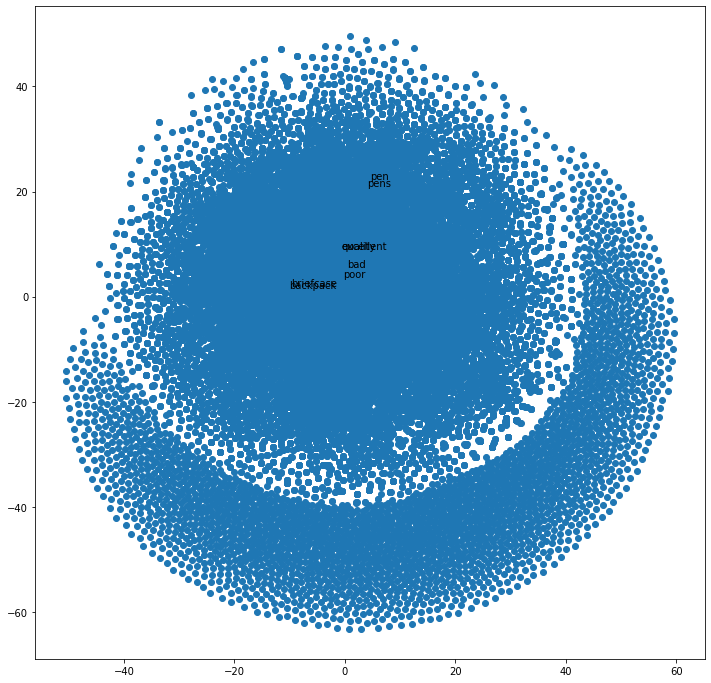

In [63]:
def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    # Label randomly subsampled 25 data points
        

    indices = list(range(len(labels)))
    #selected_indices = random.sample(indices, 25)
    selected_indices=[]
    index = labels.index("backpack")
    selected_indices.append(index)
    index = labels.index("briefcase")
    selected_indices.append(index)
    index = labels.index("quality")
    selected_indices.append(index)
    index = labels.index("poor")
    selected_indices.append(index)
    index = labels.index("excellent")
    selected_indices.append(index)
    index = labels.index("bad")
    selected_indices.append(index)
    index = labels.index("pen")
    selected_indices.append(index)
    index = labels.index("pens")
    selected_indices.append(index)
    
    
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))



plot_function = plot_with_matplotlib


plot_function(x_vals, y_vals, labels)